## WEEK 1:

#### terminal input: 
spades.py -o /home/be131-19/Lab_8_Nate/aligned -1 /data/lab8/illumina_reads_R1.fastq -2 /data/lab8/illumina_reads_R2.fastq --pacbio /data/lab8/pacbio_reads.fastq -t 1

#### terminal output:
"======= SPAdes pipeline finished WITH WARNINGS!

=== Error correction and assembling warnings:
 * 0:16:42.995   564M / 1G    WARN    General                 (kmer_coverage_model.cpp   : 218)   Too many erroneous kmers, the estimates might be unreliable
======= Warnings saved to /home/be131-19/Lab_8_Nate/aligned.fastq/warnings.log

SPAdes log can be found here: /home/be131-19/Lab_8_Nate/aligned.fastq/spades.log

Thank you for using SPAdes!"

#### Questions:

Why do we expect short reads to produce a more fragmented assembly than long reads?

Why does a single-molecule sequencing like PacBio have a higher error rate than Illumina?

## WEEK 2: 

# Running "assembly-stats" program

#### input: assembly-stats contigs.fasta
#### output:
stats for contigs.fasta
- sum = 6678635, n = 176, ave = 37946.79, largest = 414008
- N50 = 234690, n = 11
- N60 = 202142, n = 14
- N70 = 154232, n = 18
- N80 = 103367, n = 23
- N90 = 81286, n = 30
- N100 = 128, n = 176
- N_count = 0
- Gaps = 0

#### input: assembly-stats scaffolds.fasta
#### output:
stats for scaffolds.fasta
- sum = 6678655, n = 174, ave = 38383.07, largest = 414008
- N50 = 234690, n = 11
- N60 = 202142, n = 14
- N70 = 154232, n = 18
- N80 = 103367, n = 23
- N90 = 81821, n = 30
- N100 = 128, n = 174
- N_count = 20
- Gaps = 2

#### Questions: 
Why is N50 is useful statistic to calculate? Why not just list the mean or median contig length?

In your assembly, are scaffolds longer than contigs, or are scaffolds approximately equal to
contigs?


#### Extra Credit


In [2]:
from Bio import SeqIO
fasta_coverage = SeqIO.parse(open("/home/be131-19/Lab_8_Nate/aligned/contigs.fasta"), "fasta")
headers = []
for x in fasta_coverage:
    headers.append(x.id)

In [31]:
coverage = []
for y in headers:
    a = y
    cov = ''
    while not a[-1] == "_":
        cov = a[-1] + cov
        length = len(a)
        cut = length -1
        a = a[:cut]
    coverage.append(round(float(cov)))

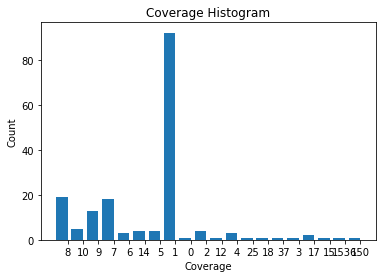

In [34]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


count = Counter(coverage)
labels, values = zip(*count.items())
indexes = np.arange(len(labels))
width = 0.75
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.title("Coverage Histogram")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.show()

#### Extra Credit Questions:
Is coverage uniformly distributed? Does it look Gaussian? Is it bimodal or trimodal?

Coverage has two modes at 1.0 and ... Here, the count of each coverage value is 2.0. Everywhere else, the histogram is uniform with a frequency of 1.0 for each coverage value. 

What explains the presence of contigs with coverage an integer multiple of the mean coverage?

# Identifying taxon from which genome originated:

### Step 1: Scan over the entire genome to locate copies of the 16S ribosomal RNA gene
#### input:
rna_hmm3.py -i /home/be131-19/Lab_8_Nate/aligned/contigs.fasta-o /home/be131-19/Lab_8_Nate/rRNA.gff

#### output:
this program output a Genome Feature Format (GFF) annotation file at the specified path (/home/be131-19/Lab_8_Nate/rRNA.gff). The output file was named "rRNA.gff". 

Next, in "rRNA.gff" I visually inspected that there were eight 23S_rRNA genes, six 16S_rRNA genes, and six 5S_rRNA genes. I deleted the 23S and 5S genes directly in the GFF file, leaving behind six 16S_rRNA genes. 

### Step 2: Extract the 16S rRNA genes directly from assembly
#### input:
bedtools getfasta -fi /home/be131-19/Lab_8_Nate/aligned/contigs.fasta -bed /home/be131-19/Lab_8_Nate/rRNA.gff

#### output:
index file /home/be131-19/Lab_8_Nate/aligned/contigs.fasta.fai not found, generating...
">NODE_23_length_103367_cov_10.081286:35530-37075"
">NODE_18_length_154232_cov_9.584186:124541-126086"
">NODE_5_length_327223_cov_9.241629:46285-47830"
">NODE_6_length_298784_cov_8.918606:13925-15470"
">NODE_4_length_332509_cov_9.114046:137011-138556"
">NODE_2_length_378948_cov_10.006665:348499-350044"

Following each fasta header was the corresponding sequence, I omitted them because they were long. Instead, I stored them in a FASTA file since they were already in FASTA format. I named this file "16SrRNA.fasta". To make sure everything ran correctly, I made sure that the names of these output sequences matched the names of the 16S sequences stored in "rRNA.gff". They matched. 

### Step 3: Comparing these genes (above) to a database of known 16S rRNA genes

I pointed my browser to: https://rdp.cme.msu.edu/seqmatch/seqmatch_intro.jsp
Then I copied the FASTA formated sequences (output in the previous step) from "16SrRNA.fasta". I pasted them into the text box with the following parameters: {Strain: Both, Source: Both, Size:>1200, Quality:Good, Taxonomy:Nomenclatural, KNN matches:20}. 

The output follows: 

rootrank Root (6) (query sequences)            
     - domain Bacteria  (6) 
         - phylum "Proteobacteria"  (6) 
            - class Gammaproteobacteria  (6) 
                - order Pseudomonadales  (6) 
                   - family Pseudomonadaceae  (6) 
                      - genus Pseudomonas  (6) 
                         NODE_23_length_103367_cov_10.081286:35530-37075  
                         NODE_2_length_378948_cov_10.006665:348499-350044 
                         NODE_6_length_298784_cov_8.918606:13925-15470
                         NODE_5_length_327223_cov_9.241629:46285-47830  
                         NODE_4_length_332509_cov_9.114046:137011-138556  
                         NODE_18_length_154232_cov_9.584186:124541-126086 
                         
Genus level identification: Pseudomonas

I came to this conclusion because each of the six 16S rRNA sequences that I ran in the SeqMatch tool was identified as part of the genus Pseudomonas. It did this by comparing each of the 16S sequences to a database of high-quality curated sequences, obtained from known bacteria. Since all of the sequences ran gave the same genus, I concluded that this was the genus. 

# Genome Annotation

## RAST

RAST says "You may upload a prokaryotic genome in one or more contigs, as either a single multitrecord FASTA format file or a Genbank format file." so I uploaded "contigs.fasta" after I made an account. On the second page I indicated that the domain was Bacteria, the genus was Pseudomonas, and chose that the genetic code was 11 (for Archea, most Bacteria, most Virii, and some Mitochondria). Then I submitted the job.
RAST then gave me a job id: 653399.

## BASys 

In BASys, I input my email into the first field, I chose "1" as the genome/contig identifier, with some research I found that bacteria in the genus Pseudomonas are gram negative (https://en.wikipedia.org/wiki/Pseudomonas_aeruginosa), I then input the genus as "Pseudomonas". I also selected that the contig is circular and chose the genetic code was bacterial. 

